⭐ ___MAKHOVA ANASTASIA___ ⭐

# ML-enhanced Statistical Arbitrage on Cointegrated Assets

## Data loading and preprocessing

We collect **hourly price data** for two highly correlated crypto assets: **Bitcoin (BTC)** and **Ethereum (ETH)**.

Cryptocurrency markets operate continuously (24/7), which makes hourly data a natural choice for intraday statistical arbitrage:
- no market open/close effects,
- no overnight gaps,
- stable time aggregation.

We use **adjusted close prices** and synchronize timestamps to ensure both assets are observed simultaneously.


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline

tickers = ["BTC-USD", "ETH-USD"]

raw = yf.download(
    tickers,
    interval="1h",
    period="730d",
    auto_adjust=True,
    progress=False
)

prices = raw["Close"].dropna()
prices = prices.dropna()


##  Spread construction and normalization

To ensure scale invariance and interpretability, we work with **log-prices**.

The spread is defined as the difference between log-prices of BTC and ETH:

$$ s_t = \log(P^{BTC}_t) - \log(P^{ETH}_t) $$

This spread represents the **relative valuation** between the two assets and is the object of mean-reversion analysis.

We standardize the spread using a rolling mean and standard deviation, obtaining the classical **z-score**:

$$z_t = \frac{s_t - \mu_t}{\sigma_t} $$

This normalization allows us to compare deviations across time and define systematic entry and exit rules.



In [2]:
logp = np.log(prices)

spread = logp["BTC-USD"] - logp["ETH-USD"]


In [3]:

LOOKBACK = 7 *24  # окно для mean/std
mu = spread.rolling(LOOKBACK).mean()
sd = spread.rolling(LOOKBACK).std()
z = (spread - mu) / sd


## Speed of mean reversion: half-life estimation

To quantify the strength and speed of mean reversion, we approximate the spread dynamics with an AR(1) model:

$$\Delta s_t = \lambda s_{t-1} + \varepsilon_t$$

The **half-life of mean reversion** is defined as:

$$HL = -\frac{\ln 2}{\lambda}$$

Intuitively, the half-life measures how long it takes for half of a deviation to dissipate.
Shorter half-life indicates stronger and more exploitable mean-reverting behavior.


In [4]:
import statsmodels.api as sm

def estimate_half_life(spread_window):
    spread_lag = spread_window.shift(1).dropna()
    delta = spread_window.diff().dropna()

    if len(spread_lag) < 10:
        return np.inf

    X = sm.add_constant(spread_lag)
    res = sm.OLS(delta.loc[spread_lag.index], X).fit()

    lambda_ = res.params.iloc[1]

    if lambda_ >= 0:
        return np.inf

    half_life = -np.log(2) / lambda_
    return half_life



## Formation period filtering

Following the classical pairs-trading literature, trading is restricted to periods where the spread exhibits **stable mean-reverting dynamics**.

We evaluate this property over a rolling **formation window**, updated at a fixed frequency.

Instead of enforcing strict stationarity tests, we rely on a **half-life constraint**, which empirically proves to be more robust for high-frequency crypto data.

Only periods that satisfy the formation criterion are allowed for trading.



> !!! Если данных много, для ускорения, можем реже обновлять фильтр. При ```STEP = 3```  Модель **без нейросети работает лучше**, а при ```STEP = 6 ``` -- **с нейросетью**. Остается решить то же быстрее: чаще высчитывать half-life или делать прогнозы логистической регрессией.

In [5]:
from statsmodels.tsa.stattools import adfuller

FORM_WIN = 90 * 24      # 90 days in hours
ADF_P = 0.3
HL_MAX = 10 * 24       # 10 days in hours

is_good_pair = pd.Series(False, index=spread.index)

STEP = 3 # обновляем фильтр раз в ... часов

last_flag = False

for t in range(FORM_WIN, len(spread), STEP):
    window_spread = spread.iloc[t-FORM_WIN:t]

    #stat, pval, *_ = adfuller(window_spread)
    hl = estimate_half_life(window_spread)

    #last_flag = (pval < ADF_P) and (hl < HL_MAX)
    last_flag = (hl < HL_MAX)

    is_good_pair.iloc[t:t+STEP] = last_flag




##  Risk controls and market shock filtering

To protect the strategy from extreme market events, we explicitly filter out **large price shocks**.

If either BTC or ETH experiences an unusually large one-period return, all trading activity is suspended at that timestamp.

This prevents the strategy from trading during:
- liquidation cascades,
- flash crashes,
- regime breaks.

Additionally, a cooldown mechanism is applied after exits to avoid rapid re-entry.


In [6]:
ENTRY_Z =2
EXIT_Z = 0.5
STOP_Z = 4.0
MAX_HOLD = 7 * 24   
MAX_Z = 1.0
Z_CAP = 3.0

pos = pd.Series(0.0, index=z.index, dtype=float)
hold = 0

COOLDOWN = 1    # часов
cooldown = 0

In [7]:
ret_btc = prices["BTC-USD"].pct_change()
ret_eth = prices["ETH-USD"].pct_change()

SHOCK_TH = 0.05  # ровно 5%

shock = (ret_btc.abs() > SHOCK_TH) | (ret_eth.abs() > SHOCK_TH)



##  Machine learning setup

Machine learning is used **only as a trade filter**, not as a direct signal generator.

The dataset is split chronologically:
- first 60% for training,
- remaining 40% for out-of-sample testing.

Training events are defined as timestamps where:
- the spread deviation exceeds the entry threshold,
- the formation filter is satisfied,
- no market shock is present.

This ensures that the ML model learns only from economically meaningful situations.


In [8]:
split_idx = int(0.6 * len(z))

train_idx = z.index[:split_idx]
test_idx  = z.index[split_idx:]


In [9]:
events_train = []

for t in range(LOOKBACK, split_idx):
    if (
        not np.isnan(z.iloc[t]) and
        is_good_pair.iloc[t] and
        (not shock.iloc[t]) and
        abs(z.iloc[t]) >= ENTRY_Z
    ):
        events_train.append(t)

events_train = np.array(events_train)

In [10]:
SPREAD_VOL_WIN = 24
spread_sigma = spread.diff().rolling(SPREAD_VOL_WIN).std()


##  Triple-barrier labeling

To generate realistic supervision labels, we use the **triple-barrier method**.

Each potential trade is evaluated using:
- a profit-taking barrier,
- a stop-loss barrier,
- a time-based vertical barrier.

Labels depend on which barrier is hit first, making the labeling process **path-dependent** and consistent with real trading constraints.

Profit and stop barriers are scaled by local spread volatility.


In [11]:
def triple_barrier_label(spread, t, sigma, pt_mult=1.0, sl_mult=1.0, max_h=MAX_HOLD):
    path = spread.iloc[t : t + max_h]

    if len(path) < max_h:
        return 0

    ret = path - spread.iloc[t]

    pt =  pt_mult * sigma.iloc[t]
    sl = -sl_mult * sigma.iloc[t]

    if np.isnan(pt) or np.isnan(sl):
        return 0

    hit_pt = np.where(ret >= pt)[0]
    hit_sl = np.where(ret <= sl)[0]

    if len(hit_pt) == 0 and len(hit_sl) == 0:
        return 0

    if len(hit_pt) == 0:
        return 0

    if len(hit_sl) == 0:
        return 1

    return 1 if hit_pt[0] < hit_sl[0] else 0


## Data-driven calibration of barriers

Instead of fixing barrier widths arbitrarily, we estimate them empirically.

For each training event, we compute:
- Maximum Favorable Excursion (MFE),
- Maximum Adverse Excursion (MAE).

These excursions are normalized by local volatility and used to estimate empirical quantiles.
The resulting multipliers define realistic, data-driven profit-taking and stop-loss levels.


## Maximum Favorable Excursion (MFE) и Maximum Adverse Excursion (MAE)

### Maximum Favorable Excursion (MFE)

**MFE** — это максимальное благоприятное движение спреда после входа в позицию:

$$
\mathrm{MFE}_i = \max_{t \in [0, H]} \left( s_{t_i + t} - s_{t_i} \right)
$$


### Maximum Adverse Excursion (MAE)

**MAE** — это максимальное неблагоприятное движение спреда против позиции:

$$
\mathrm{MAE}_i = \min_{t \in [0, H]} \left( s_{t_i + t} - s_{t_i} \right)
$$




Чтобы сделать оценки сопоставимыми во времени, мы нормализуем параметры
на локальную волатильность спреда:

$$
\mathrm{MFE}_i^{(n)} = \frac{\mathrm{MFE}_i}{\sigma_{t_i}}, \quad
\mathrm{MAE}_i^{(n)} = \frac{\mathrm{MAE}_i}{\sigma_{t_i}}
$$

где:

- $\sigma_{t_i}$ — скользящая оценка волатильности спреда в момент входа.



---

### Эмпирическая калибровка барьеров

Используя распределения нормализованных MFE и MAE на обучающей выборке,
мы выбираем квантиль, соответствующий «типичному» движению цены:

$$
\text{PT\_MULT} = Q_{0.65}\!\left( \mathrm{MFE}^{(n)} \right)
$$

$$
\text{SL\_MULT} = Q_{0.65}\!\left( -\mathrm{MAE}^{(n)} \right)
$$

Это означает:

- take-profit устанавливается так, чтобы около **65% успешных сделок**
  могли его достичь,
- stop-loss отражает **реалистичный уровень допустимого неблагоприятного движения**,
  наблюдаемый в данных.

Таким образом, уровни выхода определяются **данными**, а не произвольными константами.


In [12]:
MFE = []
MAE = []

for t in events_train:
    path = spread.iloc[t : t + MAX_HOLD]
    if len(path) < MAX_HOLD:
        continue

    ret = path - spread.iloc[t]
    MFE.append(ret.max())
    MAE.append(ret.min())

MFE = np.array(MFE)
MAE = np.array(MAE)


In [13]:
sigma_t = spread_sigma.iloc[events_train[:len(MFE)]].values

MFE_n = MFE / sigma_t
MAE_n = MAE / sigma_t


In [14]:
PT_MULT = np.quantile(MFE_n, 0.65)
SL_MULT = np.quantile(-MAE_n, 0.65)


In [15]:
PT_MULT,  SL_MULT

(np.float64(17.107509052973676), np.float64(7.120247067288529))

In [16]:
labels = []

#PT_MULT = 1.0
#SL_MULT = 1.0

for t in events_train:
    lbl = triple_barrier_label(
        spread=spread,
        t=t,
        sigma=spread_sigma,
        pt_mult=PT_MULT,
        sl_mult=SL_MULT,
        max_h=MAX_HOLD
    )
    labels.append(lbl)

labels = np.array(labels)




## Feature construction and ML model

For each training event, we construct a compact feature set capturing:
- magnitude of mispricing (|z|),
- short-term dynamics (Δz),
- local spread volatility,
- estimated half-life of mean reversion.

We use a **logistic regression model** with standardized features.
This choice ensures interpretability, stability, and robustness against overfitting.


In [17]:
X_train = pd.DataFrame({
    "abs_z": np.abs(z.iloc[events_train].values),
    "dz": (z.iloc[events_train].values - z.shift(1).iloc[events_train].values),
    "spread_vol": spread.diff().rolling(24).std().iloc[events_train].values,
    "half_life": [
        estimate_half_life(spread.iloc[t-LOOKBACK:t])
        for t in events_train
    ]
})

X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna()
y_train = np.array(labels[:len(X_train)])



In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

ml_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

ml_pipe.fit(X_train, y_train)

print("ML train accuracy:", ml_pipe.score(X_train, y_train))


ML train accuracy: 0.6875


In [19]:
base_rate = y_train.mean()
print("Base success rate:", base_rate)

Base success rate: 0.3020833333333333


-----------

## Trading logic and position sizing

Торговая стратегия построена в рамках классического **mean-reversion подхода**.

### Вход в позицию
Позиция открывается, когда нормализованный спред (z-score) существенно отклоняется от нуля:

$$\text{Long spread, если } z_t \leq -z_{\text{entry}}, \qquad
\text{Short spread, если } z_t \geq z_{\text{entry}}$$

Это соответствует ставке на возврат спреда к своему среднему значению.

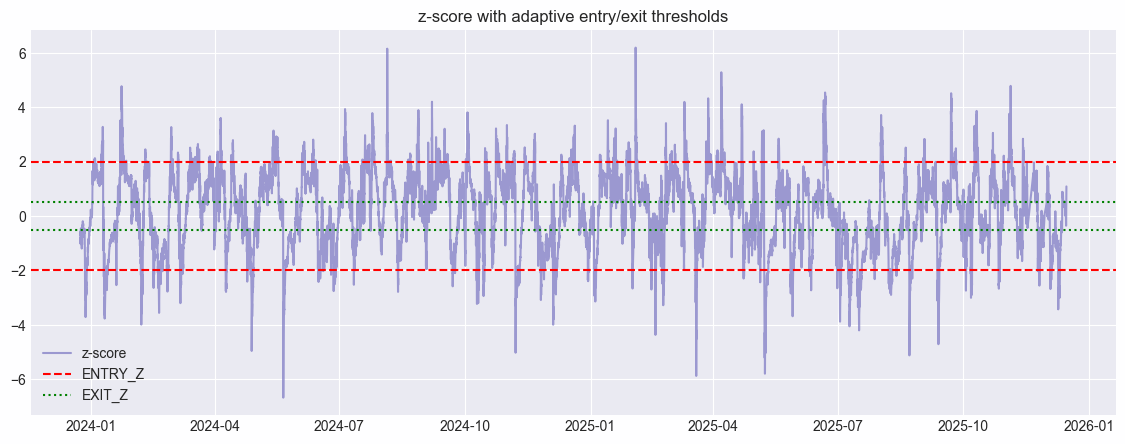
---

### Выход из позиции
Позиция закрывается при выполнении одного из условий:

1. **Mean reversion (take profit)**  
$$|z_t| \leq z_{\text{exit}}$$

2. **Stop-loss**  
$$|z_t| \geq z_{\text{stop}}$$

3. **Ограничение по времени удержания**  
$$\text{Holding time} \geq H_{\max}$$

4. **Фильтр рыночных шоков** — позиции не удерживаются и не открываются во время экстремальных движений рынка.

---

### Размер позиции (position sizing)

Размер позиции масштабируется в зависимости от величины отклонения спреда:

$$\text{size}_t = \min\left(1,\; \frac{|z_t|}{Z_{\max}}\right)$$

Итоговая позиция по спреду:

$$\text{position}_t =
\begin{cases}
-\text{size}_t, & z_t \geq z_{\text{entry}} \\
+\text{size}_t, & z_t \leq -z_{\text{entry}} \\
0, & \text{иначе}
\end{cases}$$

Таким образом:
- при небольших отклонениях позиция мала,
- при экстремальных отклонениях позиция насыщается,
- риск автоматически адаптируется к силе сигнала.

---

### Роль машинного обучения

Модель машинного обучения используется **только как фильтр сделок**:
- она оценивает вероятность успешной mean-reversion,
- сделки совершаются только если вероятность превышает базовый уровень (base rate),
- ML применяется **исключительно на out-of-sample данных**, что исключает утечки информации.


In [20]:
for t in range(1, len(z)):
    
    if cooldown > 0:
        cooldown -= 1
    if shock.iloc[t]:
        pos.iloc[t] = 0
        continue


    if np.isnan(z.iloc[t]):
        pos.iloc[t] = 0
        hold = 0
        continue

    if pos.iloc[t-1] != 0:
        hold += 1

        if abs(z.iloc[t]) >= STOP_Z:
            pos.iloc[t] = 0
            hold = 0
            cooldown = COOLDOWN
            continue

        if hold >= MAX_HOLD:
            pos.iloc[t] = 0
            hold = 0
            cooldown = COOLDOWN
            continue

        if abs(z.iloc[t]) <= EXIT_Z:
            pos.iloc[t] = 0
            hold = 0
            cooldown = COOLDOWN
        else:
            pos.iloc[t] = pos.iloc[t-1]

        continue

    if cooldown > 0:
        pos.iloc[t] = 0
        continue

    if not is_good_pair.iloc[t]:
        pos.iloc[t] = 0
        continue

    if z.iloc[t] >= ENTRY_Z:
        # ML-фильтр ТОЛЬКО на test
        if t >= split_idx:
            feat = pd.DataFrame({
                "abs_z": [abs(z.iloc[t])],
                "dz": [z.iloc[t] - z.iloc[t-1]],
                "spread_vol": [spread.diff().rolling(24).std().iloc[t]],
                "half_life": [estimate_half_life(spread.iloc[t-LOOKBACK:t])]
            })

            feat = feat.replace([np.inf, -np.inf], np.nan)

            if feat.isna().any(axis=1).iloc[0]:
                # если фичи плохие — НЕ используем ML
                prob = 1.0
            else:
                prob = ml_pipe.predict_proba(feat)[0, 1]

            if prob < base_rate:
                pos.iloc[t] = 0
                continue

        size = 1
        size = min(4.0, abs(z.iloc[t]) / MAX_Z)
        #raw_size = abs(z.iloc[t]) / Z_CAP
        #size = min(1.0, raw_size)
        #size = 1.0 / (1.0 + abs(z.iloc[t]))
        pos.iloc[t] = -size
        hold = 0
    
    elif z.iloc[t] <= -ENTRY_Z:
        if t >= split_idx:
            feat = pd.DataFrame({
                "abs_z": [abs(z.iloc[t])],
                "dz": [z.iloc[t] - z.iloc[t-1]],
                "spread_vol": [spread.diff().rolling(24).std().iloc[t]],
                "half_life": [estimate_half_life(spread.iloc[t-LOOKBACK:t])]
            })

            feat = feat.replace([np.inf, -np.inf], np.nan)

            if feat.isna().any(axis=1).iloc[0]:
                # если фичи плохие — НЕ используем ML
                prob = 1.0
            else:
                prob = ml_pipe.predict_proba(feat)[0, 1]

            if prob < base_rate:
                pos.iloc[t] = 0
                continue
        size = 1
        size = min(4.0, abs(z.iloc[t]) / MAX_Z)
        #raw_size = abs(z.iloc[t]) / Z_CAP
        #size = min(1.0, raw_size)
        #size = 1.0 / (1.0 + abs(z_adj.iloc[t]))
        pos.iloc[t] = size
        hold = 0
    else:
        pos.iloc[t] = 0


## Performance evaluation

Strategy PnL is computed based on changes in the spread.
Transaction costs are approximated by a penalty proportional to position turnover.

The Sharpe ratio is annualized using the appropriate frequency for hourly data.

We report:
- total PnL,
- total return,
- turnover,
- fraction of tradable periods.

Cumulative PnL and z-score dynamics are visualized for interpretability.



##  Performance evaluation

Для оценки качества стратегии используются следующие метрики.

---

### Profit and Loss (PnL)

Прибыль стратегии рассчитывается на основе изменений спреда:

$$\text{PnL}_t = \text{position}_{t-1} \cdot \Delta s_t$$

где $\Delta s_t = s_t - s_{t-1}$.

С учетом транзакционных издержек:

$$
\text{PnL}^{net}_t = \text{PnL}_t - c \cdot |\Delta \text{position}_t|
$$

где $c$ — фиксированная стоимость сделки.

---

### Cumulative PnL

$$\text{Cumulative PnL}_T = \sum_{t=1}^{T} \text{PnL}^{net}_t$$

Показывает абсолютную прибыль стратегии в единицах спреда.

---

### Total return

Для интерпретации в процентах используется экспоненциальное преобразование:

$$R_T = e^{\text{Cumulative PnL}_T} - 1$$

Эта величина отражает относительный прирост капитала.

---

### Sharpe ratio

Sharpe ratio измеряет **risk-adjusted доходность**:

$$\text{Sharpe} =
\sqrt{F} \cdot \frac{\mathbb{E}[r_t]}{\sigma(r_t)}$$
где:
- $r_t$ — доходности стратегии,
- $F$ — коэффициент годовой нормализации (для часовых данных $24 \times 365$).

Чем выше Sharpe, тем более эффективно стратегия компенсирует риск доходностью.

---

### Turnover

$$\text{Turnover} = \sum_t |\Delta \text{position}_t|$$

Turnover отражает:
- частоту изменения позиций,
- чувствительность стратегии к транзакционным издержкам,
- степень торговой активности.

Низкий turnover означает более «аккуратную» стратегию.

---

### Fraction tradable

$$\text{Fraction tradable} = \frac{\text{Количество периодов, разрешённых для торговли}}{\text{Общее количество периодов}}$$

Эта метрика показывает:
- как часто выполняются условия формации,
- насколько строгими являются фильтры стратегии.

Низкое значение означает высокую селективность, высокое — более агрессивную торговлю.

---

### Maximum drawdown

Максимальная просадка измеряет наихудшее падение капитала от локального максимума:

$$\text{Max DD} = \min_t \left( \frac{V_t}{\max_{u \leq t} V_u} - 1 \right)$$

Эта метрика критична для оценки устойчивости стратегии и сравнения с buy-and-hold подходами.

---

В совокупности эти метрики позволяют оценить стратегию с точки зрения:
- прибыльности,
- устойчивости,
- риска,
- транзакционных издержек,
- рыночной нейтральности.


In [21]:
dspread = spread.diff()

pnl = pos.shift(1) * dspread

COST = 0.0002
turnover = pos.diff().abs().fillna(0)

pnl_net = pnl - COST * turnover
pnl_net = pnl_net.dropna()

cum = pnl_net.cumsum()

ret_pct = np.exp(cum) - 1

Sharpe: 1.2
Total PnL (spread units): 0.6409663472948665
Total return (%): 89.83
Turnover: 100.67084611541736
Fraction tradable: 0.11602974234826215


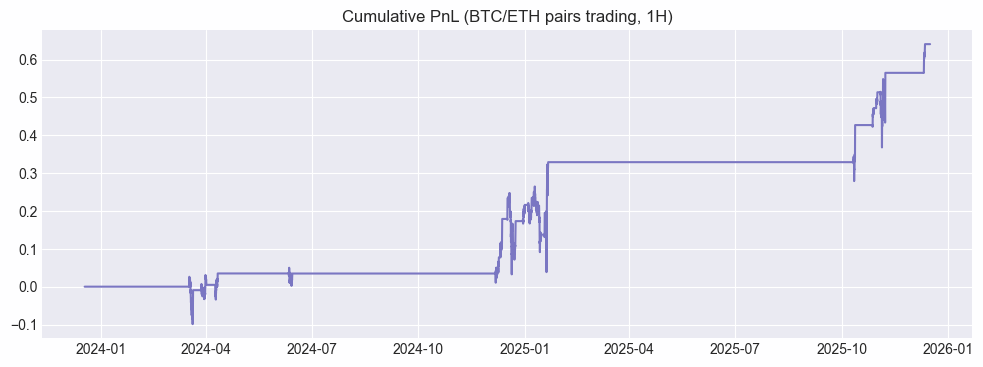

In [22]:
def sharpe(p, freq=24*365):
    return np.sqrt(freq) * p.mean() / p.std()

print("Sharpe:", round(sharpe(pnl_net), 2))
print("Total PnL (spread units):", float(cum.iloc[-1]))
print("Total return (%):", round(100 * ret_pct.iloc[-1], 2))
print("Turnover:", float(turnover.sum()))
print("Fraction tradable:", is_good_pair.mean())

plt.figure(figsize=(12,4))
plt.plot(cum)
plt.title("Cumulative PnL (BTC/ETH pairs trading, 1H)")
plt.show()

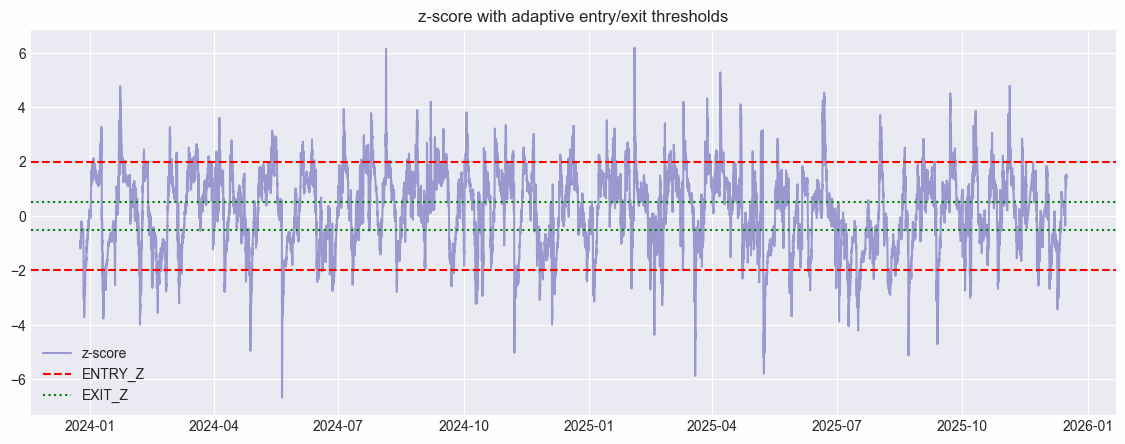

In [23]:
plt.figure(figsize=(14,5))
plt.plot(z.index, z.values, label="z-score", alpha=0.7)

plt.axhline(ENTRY_Z, color="red", linestyle="--", label="ENTRY_Z")
plt.axhline(-ENTRY_Z, color="red", linestyle="--")

plt.axhline(EXIT_Z, color="green", linestyle=":", label="EXIT_Z")
plt.axhline(-EXIT_Z, color="green", linestyle=":")

plt.legend()
plt.title("z-score with adaptive entry/exit thresholds")
plt.show()


## Train / test stability

To assess robustness, we compare cumulative PnL separately on:
- training data,
- out-of-sample test data.

Comparable performance across both periods indicates limited overfitting and stable dynamics.


In [24]:
split = int(0.6 * len(pnl_net))

pnl_train = pnl_net.iloc[:split]
pnl_test  = pnl_net.iloc[split:]

cum_train = pnl_train.cumsum()
cum_test  = pnl_test.cumsum()


TRAIN Sharpe: 0.99
TEST  Sharpe: 1.56


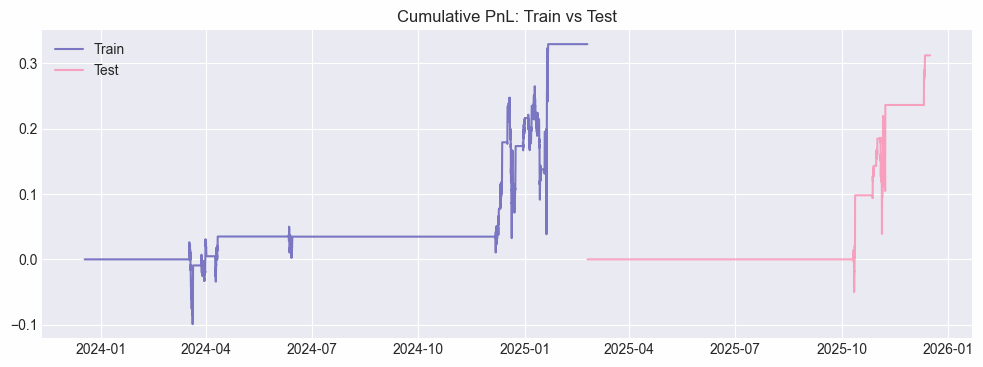

In [25]:
print("TRAIN Sharpe:", round(sharpe(pnl_train), 2))
print("TEST  Sharpe:", round(sharpe(pnl_test), 2))

plt.figure(figsize=(12,4))
plt.plot(cum_train, label="Train")
plt.plot(cum_test, label="Test")
plt.legend()
plt.title("Cumulative PnL: Train vs Test")
plt.show()

## Benchmark comparison

We compare the strategy against several benchmarks:
- BTC buy-and-hold,
- ETH buy-and-hold,
- BTC-ETH spread buy-and-hold.

For each benchmark, we compute:
- Sharpe ratio,
- maximum drawdown.

This highlights the **risk-adjusted** nature of statistical arbitrage relative to directional exposure.


In [26]:
bench_spread = spread - spread.iloc[0]
bench_ret = bench_spread.iloc[-1]

print("Benchmark spread return:", round(100 * bench_ret, 2), "%")


Benchmark spread return: 44.44 %


In [27]:
ret_btc = prices["BTC-USD"].iloc[-1] / prices["BTC-USD"].iloc[0] - 1
ret_eth = prices["ETH-USD"].iloc[-1] / prices["ETH-USD"].iloc[0] - 1

ret_equal = 0.5 * ret_btc + 0.5 * ret_eth

print("BTC return:", round(100 * ret_btc, 2), "%")
print("ETH return:", round(100 * ret_eth, 2), "%")
print("50/50 BTC-ETH:", round(100 * ret_equal, 2), "%")


BTC return: 108.64 %
ETH return: 33.78 %
50/50 BTC-ETH: 71.21 %


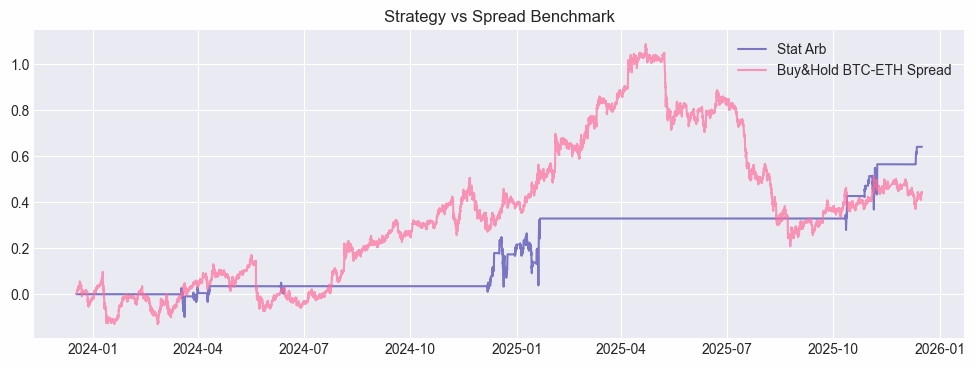

In [28]:
plt.figure(figsize=(12,4))
plt.plot(cum, label="Stat Arb")
plt.plot(bench_spread, label="Buy&Hold BTC-ETH Spread", alpha=0.7)
plt.legend()
plt.title("Strategy vs Spread Benchmark")
plt.show()

## Risk characteristics

Finally, we analyze:
- correlation between strategy returns and BTC returns,
- maximum drawdowns across strategies.

The results confirm that the strategy is:
- weakly correlated with the market,
- significantly more drawdown-resilient than buy-and-hold benchmarks.

This confirms the market-neutral nature of the approach.


In [29]:
strat_ret = pnl_net
btc_ret = prices["BTC-USD"].pct_change().loc[strat_ret.index]

print("Corr(strategy, BTC):", strat_ret.corr(btc_ret))


Corr(strategy, BTC): 0.05513893628821537


In [30]:

strat_ret = pnl_net.copy()

# доходности BTC и ETH
btc_ret = prices["BTC-USD"].pct_change().loc[strat_ret.index]
eth_ret = prices["ETH-USD"].pct_change().loc[strat_ret.index]

# спред buy&hold как бенчмарк
spread_ret = spread.diff().loc[strat_ret.index]


In [31]:
def sharpe_ratio(r, freq=24*365):
    r = r.dropna()
    return np.sqrt(freq) * r.mean() / r.std()


In [32]:
print("Sharpe Strategy:", round(sharpe_ratio(strat_ret), 2))
print("Sharpe BTC:", round(sharpe_ratio(btc_ret), 2))
print("Sharpe ETH:", round(sharpe_ratio(eth_ret), 2))
print("Sharpe Spread BH:", round(sharpe_ratio(spread_ret), 2))


Sharpe Strategy: 1.2
Sharpe BTC: 1.0
Sharpe ETH: 0.56
Sharpe Spread BH: 0.54


In [33]:
def max_drawdown(ret):
    curve = (1 + ret.fillna(0)).cumprod()
    running_max = curve.cummax()
    drawdown = curve / running_max - 1
    return drawdown.min()


In [34]:
print("Max DD Strategy:", round(100 * max_drawdown(strat_ret), 2), "%")
print("Max DD BTC:", round(100 * max_drawdown(btc_ret), 2), "%")
print("Max DD ETH:", round(100 * max_drawdown(eth_ret), 2), "%")
print("Max DD Spread BH:", round(100 * max_drawdown(spread_ret), 2), "%")


Max DD Strategy: -20.97 %
Max DD BTC: -34.82 %
Max DD ETH: -65.27 %
Max DD Spread BH: -60.11 %


In [35]:
results = pd.DataFrame({
    "Sharpe": [
        sharpe_ratio(strat_ret),
        sharpe_ratio(btc_ret),
        sharpe_ratio(eth_ret),
        sharpe_ratio(spread_ret)
    ],
    "Max Drawdown (%)": [
        100 * max_drawdown(strat_ret),
        100 * max_drawdown(btc_ret),
        100 * max_drawdown(eth_ret),
        100 * max_drawdown(spread_ret)
    ]
}, index=[
    "Stat Arb Strategy",
    "BTC Buy&Hold",
    "ETH Buy&Hold",
    "BTC-ETH Spread BH"
])

results


,Sharpe,Max Drawdown (%)
Stat Arb Strategy,1.201109,-20.974540
BTC Buy&Hold,1.000435,-34.816163
ETH Buy&Hold,0.559437,-65.266919
BTC-ETH Spread BH,0.536846,-60.109449


### Без нейросети

In [36]:
for t in range(1, len(z)):
    
    if cooldown > 0:
        cooldown -= 1
    if shock.iloc[t]:
        pos.iloc[t] = 0
        continue


    if np.isnan(z.iloc[t]):
        pos.iloc[t] = 0
        hold = 0
        continue

    if pos.iloc[t-1] != 0:
        hold += 1

        if abs(z.iloc[t]) >= STOP_Z:
            pos.iloc[t] = 0
            hold = 0
            cooldown = COOLDOWN
            continue

        if hold >= MAX_HOLD:
            pos.iloc[t] = 0
            hold = 0
            cooldown = COOLDOWN
            continue

        if abs(z.iloc[t]) <= EXIT_Z:
            pos.iloc[t] = 0
            hold = 0
            cooldown = COOLDOWN
        else:
            pos.iloc[t] = pos.iloc[t-1]

        continue

    if cooldown > 0:
        pos.iloc[t] = 0
        continue

    if not is_good_pair.iloc[t]:
        pos.iloc[t] = 0
        continue

    if z.iloc[t] >= ENTRY_Z:
        size = 1
        size = min(4.0, abs(z.iloc[t]) / MAX_Z)
        #raw_size = abs(z.iloc[t]) / Z_CAP
        #size = min(1.0, raw_size)
        #size = 1.0 / (1.0 + abs(z.iloc[t]))
        pos.iloc[t] = -size
        hold = 0
    
    elif z.iloc[t] <= -ENTRY_Z:
        size = 1
        size = min(4.0, abs(z.iloc[t]) / MAX_Z)
        #raw_size = abs(z.iloc[t]) / Z_CAP
        #size = min(1.0, raw_size)
        #size = 1.0 / (1.0 + abs(z_adj.iloc[t]))
        pos.iloc[t] = size
        hold = 0
    else:
        pos.iloc[t] = 0


Sharpe: 1.21
Total PnL (spread units): 0.6534474469426033
Total return (%): 92.22
Turnover: 102.86376824387031
Fraction tradable: 0.11602974234826215


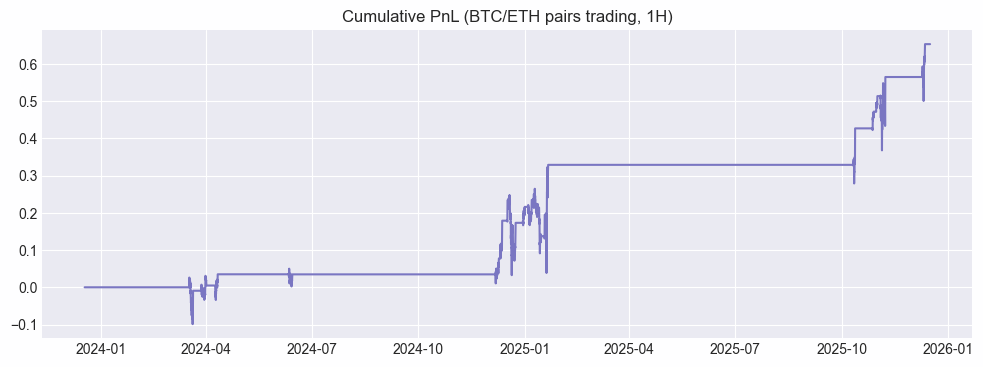

In [37]:
dspread = spread.diff()

pnl = pos.shift(1) * dspread

COST = 0.0002
turnover = pos.diff().abs().fillna(0)

pnl_net = pnl - COST * turnover
pnl_net = pnl_net.dropna()

cum = pnl_net.cumsum()

ret_pct = np.exp(cum) - 1
def sharpe(p, freq=24*365):
    return np.sqrt(freq) * p.mean() / p.std()

print("Sharpe:", round(sharpe(pnl_net), 2))
print("Total PnL (spread units):", float(cum.iloc[-1]))
print("Total return (%):", round(100 * ret_pct.iloc[-1], 2))
print("Turnover:", float(turnover.sum()))
print("Fraction tradable:", is_good_pair.mean())

plt.figure(figsize=(12,4))
plt.plot(cum)
plt.title("Cumulative PnL (BTC/ETH pairs trading, 1H)")
plt.show()

# Literature:

- Avellaneda & Lee (2010)
“Statistical Arbitrage in the US Equities Market”

- Gatev, Goetzmann, Rouwenhorst (2006)
“Pairs Trading: Performance of a Relative-Value Arbitrage Rule”

- Marcos López de Prado “Advances in Financial Machine Learning”

- Ernest P. Chan “Algorithmic Trading”